In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
output_dir = "graficos_pisos_edificio"
os.makedirs(output_dir, exist_ok=True)

# Se crea un directorio aparte para ir almacanando los plots por distrito

In [4]:
nepal = pd.read_csv("C:\\Users\\inilo\\The_Bridge\\Iñigo\\EDA_Iñigo_Lopez\\data\\eq2015.csv")
fuente_1 = "https://www.kaggle.com/datasets/sanskarnegi/nepal-earthquake-2015"

In [5]:
# Crear nueva columna para agrupar pisos
nepal["floors_grouped"] = nepal["count_floors_pre_eq"].apply(lambda x: str(x) if x in [1, 2, 3] else "4+")

In [6]:
distritos = nepal["district_name"].unique()
distritos

# Se crea una variable que almacena los nombres de los distritos afectados por terremotos

array(['Okhaldhunga', 'Sindhuli', 'Ramechhap', 'Dolakha', 'Sindhupalchok',
       'Kavre', 'Nuwakot', 'Rasuwa', 'Dhading', 'Makwanpur', 'Gorkha'],
      dtype=object)

In [7]:
graficos_por_distrito = {}

# Se crea un diccionario que almacena los path de cada plot generado

In [8]:
for distrito in distritos: # Se recorren todos los distritos en la lista distritos
    df_distrito = nepal[nepal["district_name"] == distrito] # Se define esta variable como el nombre del distrito
    
    # Se agrupan los valores por número de pisos (floors_grouped) y el grado de destrucción
    df_grouped = df_distrito.groupby(["floors_grouped", "damage_grade"]).size().unstack(fill_value=0)
    
    # Con esto nos aseguramos de que todos los grados de destrucción estén en el dataframe agrupado
    todos_los_grados = ["Grade 1", "Grade 2", "Grade 3", "Grade 4", "Grade 5"]
    df_grouped = df_grouped.reindex(columns=todos_los_grados, fill_value=0)

    # Misma para poder comprobar el número de pisos
    orden_pisos = ["1", "2", "3", "4+"]
    df_grouped = df_grouped.reindex(orden_pisos).fillna(0)

    # Se normalizan los resultados para poder ver los plots a la misma altura a pesar de tener menos cantidad de datos por categoríar
    df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0).fillna(0)

    # Se crea la figura
    fig, ax = plt.subplots(figsize=(10, 10))
    df_normalized.plot(kind='bar', stacked=True, colormap='viridis', ax=ax, legend=False)

    # Se añaden las etiquetas
    plt.xlabel('Número de pisos')
    plt.ylabel('Proporción de edificios')
    plt.title(f'Distrito: {distrito}')
    plt.xticks(rotation=0)
    ax.set_ylim(0, 1)

    # Con estas líneas de código se añaden los porcentajes correspondientes de cada porción de los barplots en %
    for i, (idx, row) in enumerate(df_normalized.iterrows()):
        y_offset = 0
        for damage_grade, value in row.items():
            if value > 0:
                ax.text(
                    i + 0.48,
                    y_offset + value / 2, 
                    f"{value * 100:.1f}%", 
                    ha='right', 
                    va='center',
                    fontsize=10,
                    color='black'
                )
            y_offset += value

    # Se guarda la imagen en memoria
    img_path = os.path.join(output_dir, f"{distrito}.png")
    plt.savefig(img_path, bbox_inches="tight", dpi=150)
    plt.close(fig)

    # Se guarda la ruta de la imagen
    graficos_por_distrito[distrito] = img_path

In [9]:
# Para ir haciendo los tests estadíticos por distrito se aislan los datos de cada distrito y se trabaja con ellos
lista_gorkha = nepal[nepal["district_name"] == "Gorkha"]

In [ ]:
# Se agrupan los pisos en categorías
lista_gorkha["pisos_agrupados"] = pd.cut(
    lista_gorkha["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_13184\1604154669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_gorkha["pisos_agrupados"] = pd.cut(


In [ ]:
tabla_contingencia = pd.crosstab(lista_gorkha["pisos_agrupados"], lista_gorkha["damage_grade"])
print(tabla_contingencia)

# Se crea una tabal de contingencia que clasifica el número de edificios en función del grado de destrucción y el número de pisos

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso              1828     1994     1835     1748     4281
2 pisos             1622     5525    11842    18156    21041
3 pisos              618      867     1718     2588     1777
4+ pisos             283      169      112       44       26


In [12]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

# Se realiza el test de Chi-cuadrado

Chi² = 7126.82
Grados de libertad = 12
p-valor = 0.0000e+00


In [13]:
import numpy as np
import seaborn as sns

# Se importan las librerías para hacer el heatmap de residuos estandarizados

In [14]:
# Se calculan los residuos estandarizados
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

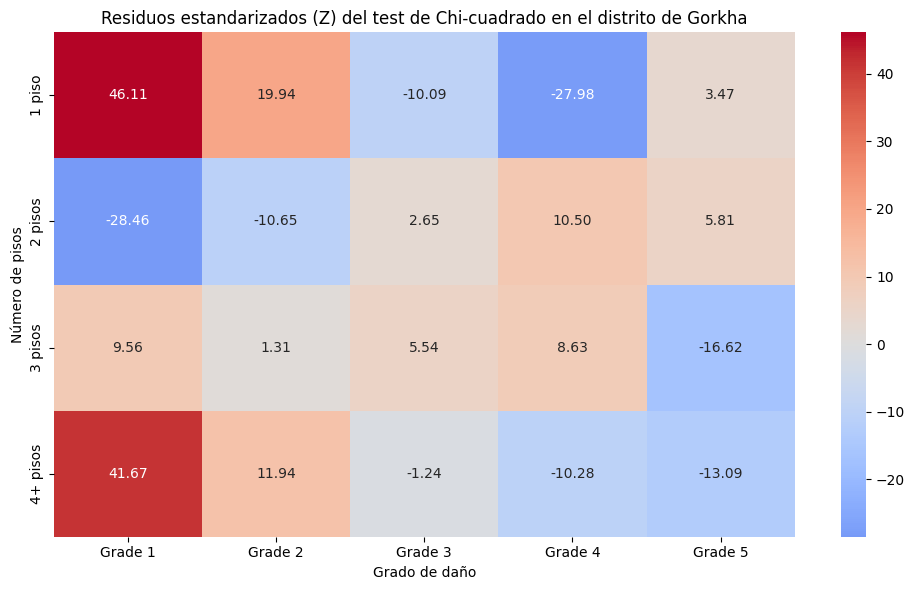

In [15]:
# Se crea el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Residuos estandarizados (Z) del test de Chi-cuadrado en el distrito de Gorkha")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [ ]:
# Se repite el proceso para los demás distritos

In [16]:
lista_dolakha = nepal[nepal["district_name"] == "Dolakha"]

In [17]:
lista_dolakha["pisos_agrupados"] = pd.cut(
    lista_dolakha["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_13184\3674401834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_dolakha["pisos_agrupados"] = pd.cut(


In [18]:
tabla_contingencia = pd.crosstab(lista_dolakha["pisos_agrupados"], lista_dolakha["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso               448      390      368      541     2298
2 pisos              408     1163     2250     5081    12830
3 pisos              277     1233     3814     8720    20073
4+ pisos             220      207       88       67      163


In [19]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 5818.98
Grados de libertad = 12
p-valor = 0.0000e+00


In [ ]:
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

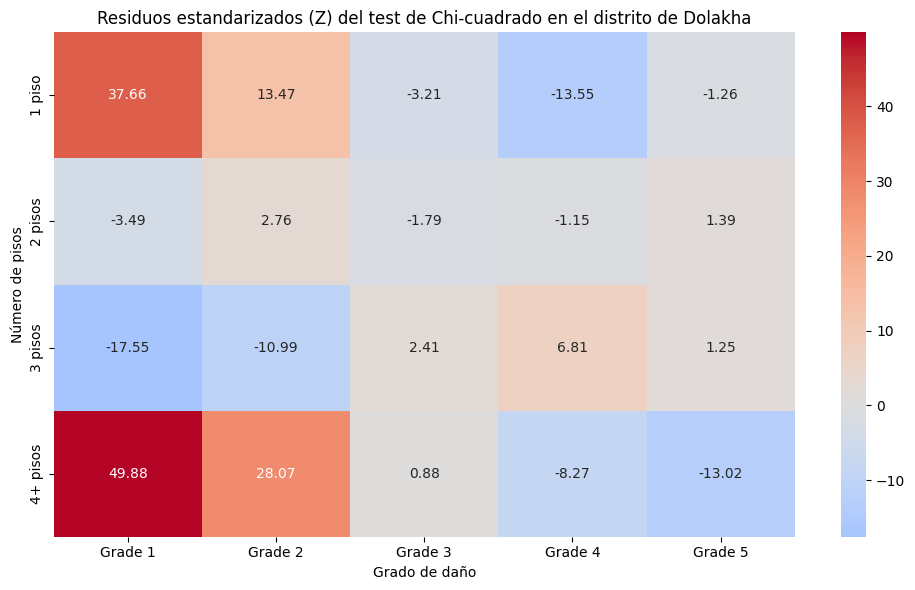

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Residuos estandarizados (Z) del test de Chi-cuadrado en el distrito de Dolakha")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [22]:
lista_makwanpur = nepal[nepal["district_name"] == "Makwanpur"]

In [23]:
lista_makwanpur["pisos_agrupados"] = pd.cut(
    lista_makwanpur["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_13184\419498621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_makwanpur["pisos_agrupados"] = pd.cut(


In [24]:
tabla_contingencia = pd.crosstab(lista_makwanpur["pisos_agrupados"], lista_makwanpur["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso             16249     8523     4701     2088     2243
2 pisos            14908    11515    12583     8220     5264
3 pisos             1218     1025     1197      601      352
4+ pisos             165       72       44       19        7


In [25]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 5414.20
Grados de libertad = 12
p-valor = 0.0000e+00


In [26]:
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

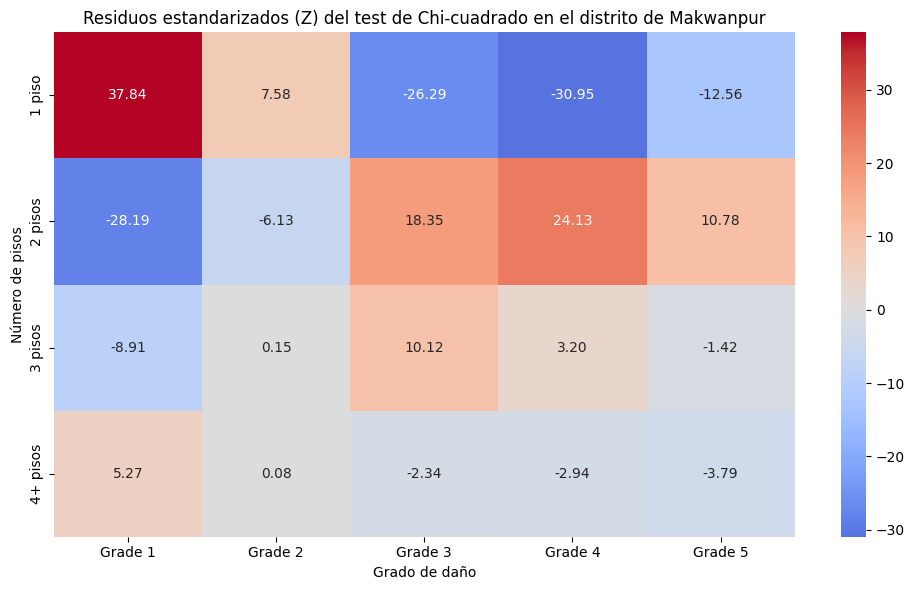

In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Residuos estandarizados (Z) del test de Chi-cuadrado en el distrito de Makwanpur")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [28]:
lista_rasuwa = nepal[nepal["district_name"] == "Rasuwa"]

In [29]:
lista_rasuwa["pisos_agrupados"] = pd.cut(
    lista_rasuwa["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_13184\3035535953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_rasuwa["pisos_agrupados"] = pd.cut(


In [30]:
tabla_contingencia = pd.crosstab(lista_rasuwa["pisos_agrupados"], lista_rasuwa["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso               101      113      183      374     2269
2 pisos               95      148      477     1439     5812
3 pisos               45       55      103      248     1081
4+ pisos              36       27       19        3       16


In [31]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 956.62
Grados de libertad = 12
p-valor = 3.9515e-197


In [32]:
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

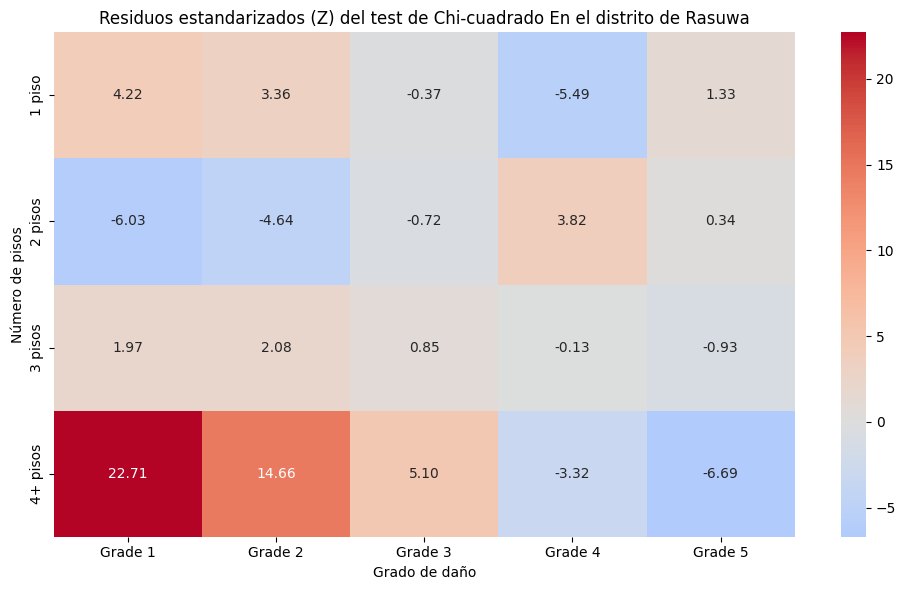

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Residuos estandarizados (Z) del test de Chi-cuadrado En el distrito de Rasuwa")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()